# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.linalg

## Generating the data

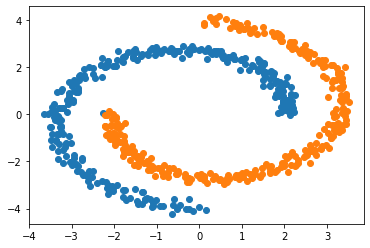

In [2]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    def similarity(x_i,x_j):
        return np.exp(-(x_i-x_j)@(x_i-x_j)/(2*var))
    
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.array([[similarity(X[i],X[j]) for i in range(n)] for j in range(n)])

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = np.where(similarities >= eps, similarities, 0)

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            sorted_indices = np.argsort(-similarities[i,:])[1:k+1] #We exclude the first one (self-similarity) and keep only the k nearest indices
            W[i,sorted_indices] = similarities[i,sorted_indices]
            W[sorted_indices,i] = similarities[sorted_indices,i] #Making the graph undirected by having a symetric matrix

    return W


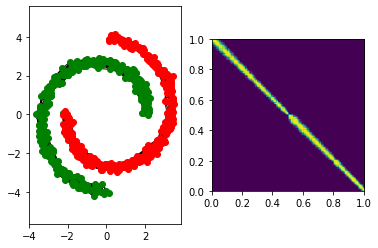

In [4]:
# Example

W = build_similarity_graph(X, eps=0.8)

plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    n = W.shape[0]
    D = np.diag([np.sum(W[:,i]) for i in range(n)])
    
    # for example (unnormalized): L = D - W
    if laplacian_normalization == "unn":
        L = D - W
        
    if laplacian_normalization == "sym":
        sqrtinvD = np.diag([1/np.sqrt(D[i,i]) for i in range(n)])
        L = np.eye(n) - (sqrtinvD@W)@sqrtinvD
        
    if laplacian_normalization == "rw":
        L = np.eye(n) - np.diag([1/D[i,i] for i in range(n)])@W
    return L

## Clustering

In [45]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eig = scipy.linalg.eig(L)
    E = np.diag(eig[0][eig[0].argsort()])
    U = eig[1][:,eig[0].argsort()]
    
    if chosen_eig_indices==None:
        eigens = eig[0][eig[0].argsort()]
        gap = eigens[1:] - eigens[:-1] #Successive gaps between the eigenvalues
        
        l = np.where(np.logical_and(gap[:-1]*5 < gap[1:],eigens[:-2] != 0))[0] #List of indices where the condition is satisfied
        
        if l.shape[0] == 0: #No gap really big
            gap_position = 1 #We only keep the second eigenvalue
        else:
            gap_position = np.min(l) #Elbow method, gap targeted = 5 times the previous gap
            
        indices = np.arange(0,gap_position+1)
    else:
        indices = chosen_eig_indices
        
    feature_matrix = np.real(U[:,indices])
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    Y = KMeans(num_classes).fit_predict(feature_matrix)
    return Y

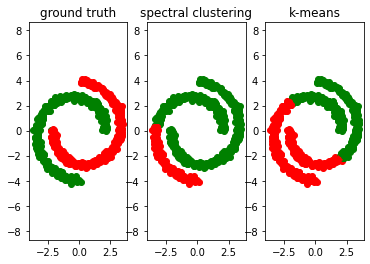

In [7]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [8]:
def parameter_sensitivity(parameter_type,parameter_candidate):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [95]:
def image_segmentation(input_img='four_elements.bmp',eps=0,k=0,num_classes=2,laplacian_normalization = 'unn',chosen_eig_indices=None):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0

    W = build_similarity_graph(Xr, var=var, k=k, eps=eps)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

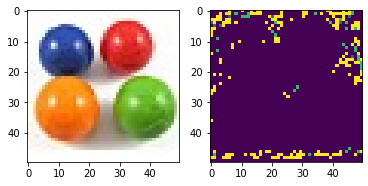

In [10]:
image_segmentation()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

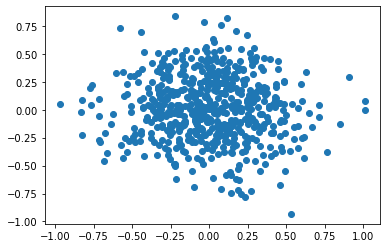

In [11]:
for fn in [worst_case_blob]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600,delta=0)
    plot_clusters(X, Y, fignum=str(fn))

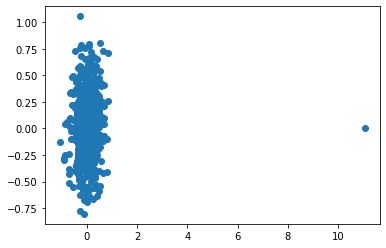

In [12]:
for fn in [worst_case_blob]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600,delta=10)
    plot_clusters(X, Y, fignum=str(fn))

The last sample of the blob is replaced by (max(X) + delta, 0) ie the parameter delta allows to chose how much of an outlier is the last sample.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

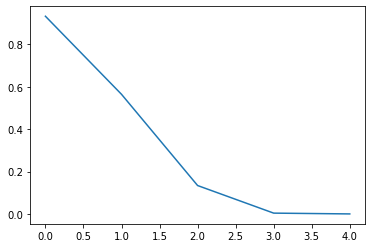

In [13]:
eps = np.zeros(5)

for i in range(5):
    for fn in [worst_case_blob]:
        X, Y = fn(num_samples=600,delta=i)
        similarities = build_similarity_graph(X)
        eps[i] = np.min(np.extract(min_span_tree(-similarities),similarities)) #Smallest similarity in the max span tree

plt.plot(np.arange(5),eps,label="epsilon")

Obviously as the vertice connecting the outlier to the blob converges to 0, the maximum epsilon keeping a connected graph converges to 0. It is a bad idea to keep a connected graph when there are at least two extremely dissimilar groups - here the outlier and the blob - as you then have to keep almost each vertice and you get an almost fully connected graph.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

If the graph is not connected, there are natural clusters appearing as each connected part would be a cluster. The Laplacian can then be rewritten as block-diagonal and these clusters are easy to compute as we just have to assign all the points in a block to the same cluster, with one cluster for each block. This can be done using the eigenvectors associated to eigenvalue 0 as they are indicator vectors.

k-NN graphs are more difficult to make connected than epsilon-graphs. Indeed, using the example above, to have a connected graph, we can take the epsilon value that keeps only one vertice between the outlier and the blob, while a k-nn would need to have k=number of samples in the blob + 1, and then instead of having only one vertice between the outlier and the blob we would have ALL the samples in the blob connecting to the outlier. In the end epsilon-graph are far more "fine grained" when you want to have them connected - you can approximately choose how much connections you want between parts.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

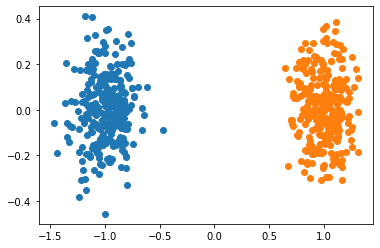

In [50]:
blobs?
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

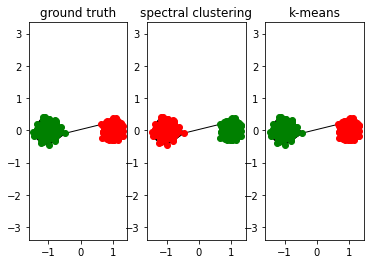

In [51]:
num_classes = 2

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,eps=eps)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

In the course, we showed that the clustering could be done using the second eigenvector, assigning the cluster for the i-th sample depending on the sign of the i-th component. In my code I did a K-means on only this eigenvector so the frontier is not exactly 0 but follows the same logic - smaller than frontier -> cluster 1, greater than frontier -> cluster 2.

The two methods are both correct in their assignments as the two blobs are linearly separable and symetric, which greatly helps the K-means algorithm.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

In [52]:
num_classes = 2

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,eps=eps*1.1) #Just a very small increase to drop the last vertice between the two components
L = build_laplacian(W)

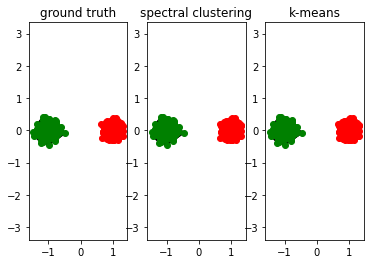

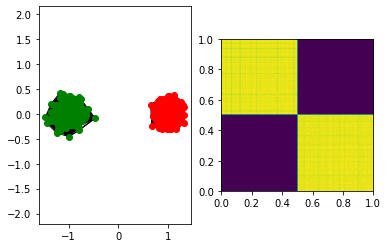

In [53]:
Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

plot_graph_matrix(X, Y, W) 

As the graph is split into two connected parts, the Laplacian is block diagonal and we can assign the clusters using the blocks, which can be done choosing the first eigenvector of each block - which are associated to the eigenvalue 0 and are indicator vectors - ie the 0th and 1th ones when we sort according to the eigenvalues.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

I implemented a kind of elbow method : the gaps between successive eigenvalues are computed, and we take all the eigenvectors corresponding to the eigenvalues before a "big gap" - big here is defined as five times the previous gap - such that the last eigenvalue is not 0 - else the gap is always attained for the first non-null eigenvalue because 5*0 = 0.

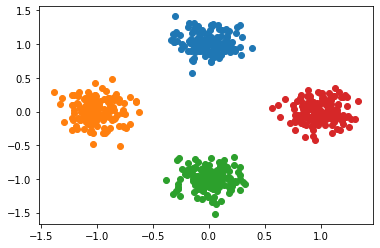

In [56]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

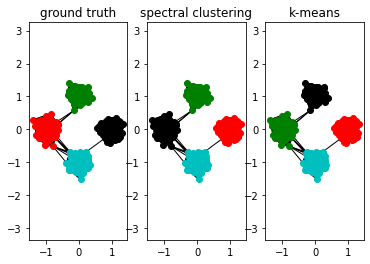

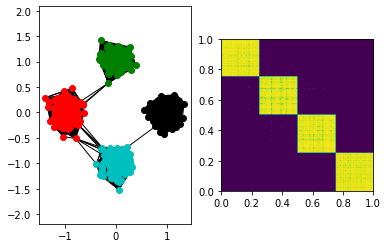

In [57]:
num_classes = 4

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,eps=eps)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

plot_graph_matrix(X, Y, W) 

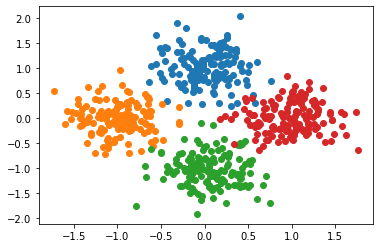

In [20]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.3)
plot_clusters(X, Y)

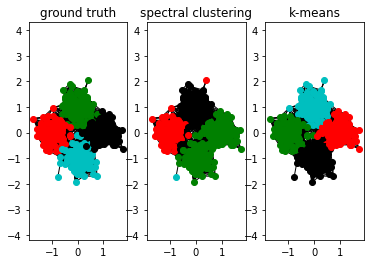

In [21]:
num_classes = 4

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,eps=eps)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

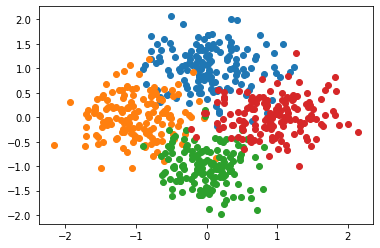

In [59]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.4)
plot_clusters(X, Y)

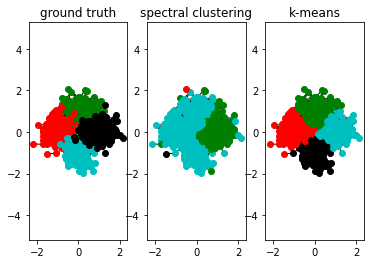

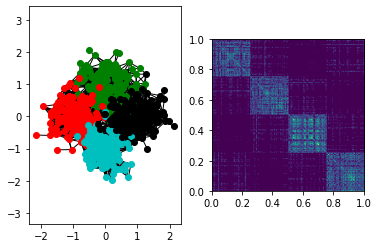

In [60]:
num_classes = 4

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,eps=eps)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

plot_graph_matrix(X, Y, W) 

When the variance increases, the blobs start covering each other and not clearly separable, the spectral clustering fails in this case as the strength of the diagonal blocks fades while "ghost" blocks appear elsewhere, so the first eigenvector of each block - associated to the eigenvalue 0 in the case of non-connected parts - drift away from indicator vectors, thus the misclassifications.

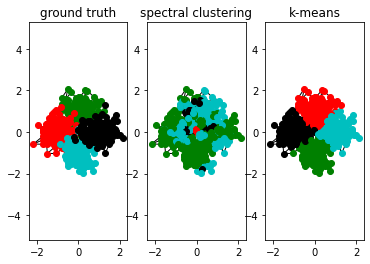

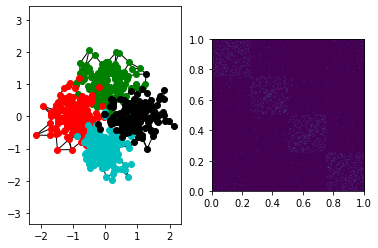

In [61]:
num_classes = 4

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,k=3)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

plot_graph_matrix(X, Y, W) 

Using a k-nn graph does not seem to improve the result.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I used k-means on the chosen vectors to assign the clusters as it is easily generalizable for more than one vector and for an arbitrary number of clusters, and because it can mimic the behavior of tresholding as the decision regions frontiers are straight lines.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

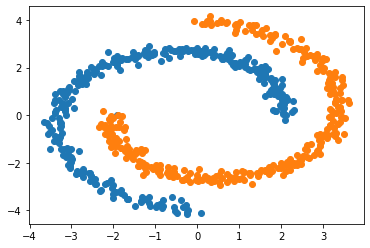

In [25]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

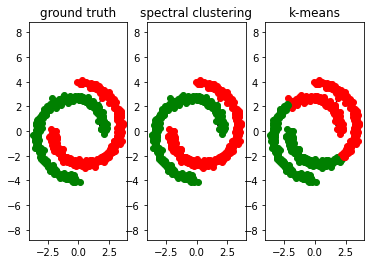

In [26]:
num_classes = 2

similarities = build_similarity_graph(X)
eps = np.min(np.extract(min_span_tree(-similarities),similarities))
W = build_similarity_graph(X,eps=eps)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

K-means is based on the euclidean distance, so its covered areas are simplices which cannot get the correct shape here, whereas spectral clustering is only interested on the underlying graph, here almost block-diagonal as we have kept the smallest epsilon possible, so the two connected parts appear clearly. In other words, spectral clustering is not affected by the shape of the data but only by the underlying graph.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

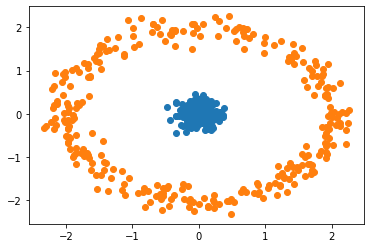

In [62]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

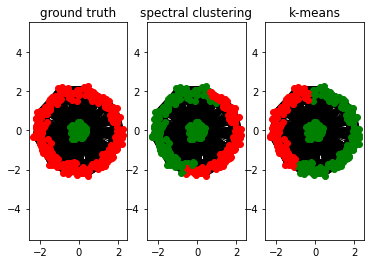

In [69]:
num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,eps=0.25)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

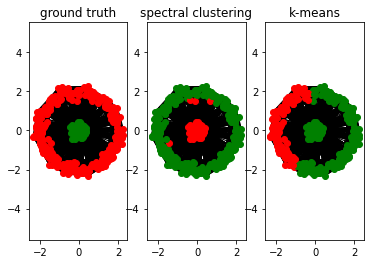

In [70]:
num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,eps=0.25)
L = build_laplacian(W,laplacian_normalization="rw")
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

The random walk laplacian sees the partitioning problem as trying to find two parts for which a random walk with the jumping probability $P = D^{-1}W$ rarely jumps from one to the other - we saw an equivalence in the course between that and the NCut problem. It looks obvious that the cut given by the clustering with the random walk laplacian indeed defines such two parts.

The main difference resides in the problem tackled, using the second eigenvector for $L_rw$ tries to minimize $\sum w_{ij}(\frac{1}{vol(A)} + \frac{1}{vol(B)})$ while for $L$ it minimizes $\sum w_{ij}(\frac{1}{|A|} + \frac{1}{|B|})$, so when there are a lot of transition vertices the results are different - if we used the minimum epsilon keeping the graph connected we would no longer see a difference.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

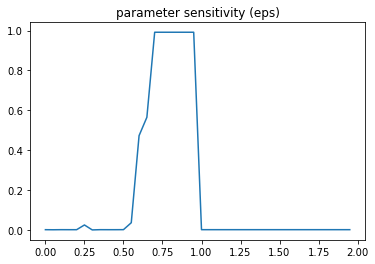

In [72]:
parameter_sensitivity('eps',np.arange(0,2,0.05))

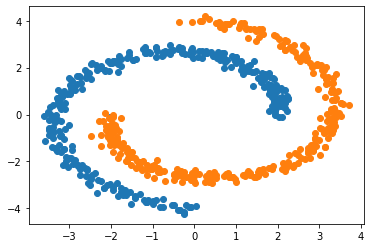

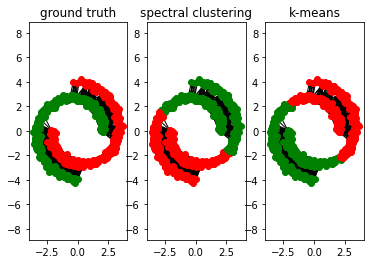

In [82]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,eps=0.5)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

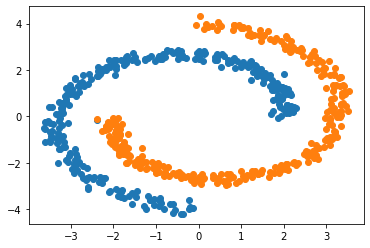

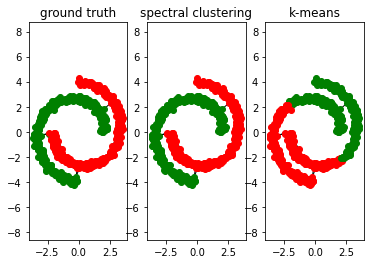

In [73]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,eps=0.75)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

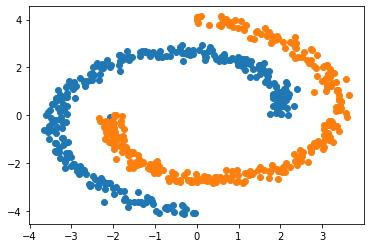

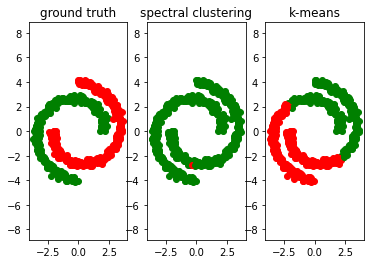

In [74]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,eps=1)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As we can see, an epsilon too small gives a fully connected graph so the clustering is similar to a k-means, when epsilon is good the graph is still connected but sparsely between the parts, and when it is too high there are no more connections and the clustering fails.

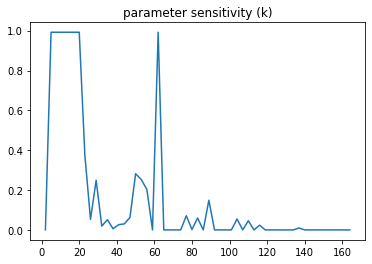

In [79]:
parameter_sensitivity('k',np.arange(2,166,3))

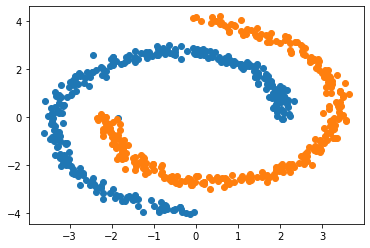

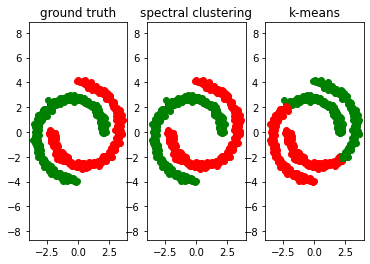

In [80]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,k=15)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

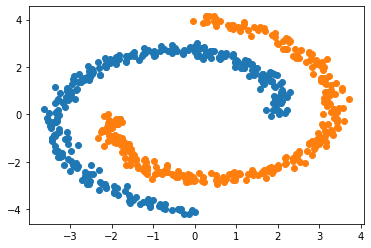

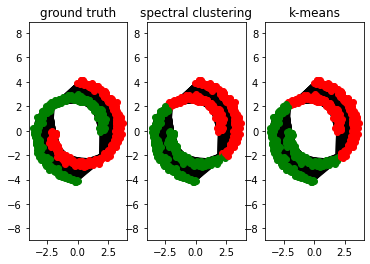

In [81]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

similarities = build_similarity_graph(X)
W = build_similarity_graph(X,k=100)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Here again the same reasoning applies. If there are too many connections the spectral clustering looks like a k-means, if there are just as needed it is good.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

My strategy was to use a really strong epsilon value to ensure that only

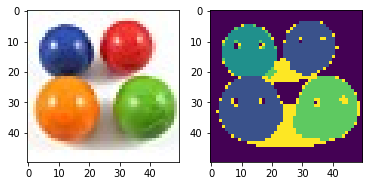

In [97]:
image_segmentation('four_elements.bmp',eps=0.95,k=0,num_classes=5,laplacian_normalization = 'rw',chosen_eig_indices=None)

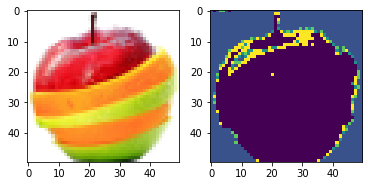

In [98]:
image_segmentation('fruit_salad.bmp',eps=0.95,k=0,num_classes=5,laplacian_normalization = 'rw',chosen_eig_indices=None)

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

We could downsample the image ie resize it to a 355px x 200 px image and performs clustering on it, then interpolates the result on the whole image. 

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 